# Initialisation
## Import packages

In [2]:
import pandas as pd
import numpy as np
# import mplhep as hep
from tqdm import tqdm
import  matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 150)

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from iminuit import Minuit

## Define the parameters and predefined functions

In [3]:
parquetcode = 'x30x20'
filecode = '_InfAwar_test_40_200'

train_hp = {
    "lr":0.003,
    "batch_size":20000,
    "N_epochs":200,
    "seed":0,
    'eplim':40
}
MInum = 140
nodes = [100,100]
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
set_seed(train_hp['seed'])

def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))

## Define the Net

In [4]:
#Define the Net
class Net(nn.Module):
    def __init__(self, n_features=40, nodes=[100,100], output_nodes=5):
        super(Net, self).__init__()
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes)-1):
            self.layers.append(nn.Linear(n_nodes[i], n_nodes[i+1]))
            self.layers.append(nn.ReLU())

    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        # Apply softmax
        return torch.softmax(out, dim=1)

## **Inference Aware Loss**

In [5]:
class InfAwareLoss(nn.Module):
    def __init__(self,weight,i,epoch):
        super(InfAwareLoss, self).__init__()
        self.weight = weight
        self.i = i
        self.epoch =epoch
    
    def forward(self,input,target):
        while self.i > self.epoch:
            # Input = torch.tensor(input)
            # Target = torch.tensor(target,dtype=torch.int8)
            label = torch.argmax(target,dim=1)
            pred = torch.argmax(input,dim=1)
            # plt.hist(pred)
            plt.show()
            weight = torch.tensor(self.weight.values)
            cm = torch.zeros(7,7)
            for t, p, w in zip(label.view(-1), pred.view(-1), weight.view(-1)):
                cm[p,t] += 1
            cm =cm[1:, :]
            O = cm.sum(dim=1)
            # print(cm)
            # print(O)
            def NLL(mu):
                mu0 =torch.tensor([1.0])
                theta = torch.cat((mu0,mu))
                return -(O@(torch.log(cm@theta+1e-3))-(cm@theta).sum())
            mu = torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0],requires_grad=True)
            hess = torch.func.hessian(NLL)(mu)
            # print(hess)
            # print(torch.det(hess))
            I = torch.inverse(hess_to_tensor(hess))
            # print(hess)
            loss = torch.trace(I)**0.5 
            # print(loss)
            return loss.clone().detach().requires_grad_(True)
        else:
            return torch.tensor([0.0],requires_grad=True)


## Define the Trainnning

In [6]:
#Define the trainning function
from NNfunctions import get_batches, get_total_loss
def train_network_cross_entropy(model, X_train,X_test,y_train,y_test,weight, train_hp={}):
    optimiser = torch.optim.Adam(model.parameters(), lr=train_hp["lr"])

    X_train =X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    
    ce_loss = nn.CrossEntropyLoss()
    train_loss, test_loss = [], []
    i = 0
    eplim = train_hp['eplim']
    epchs = train_hp['N_epochs']

    print(">> Training...")
    with tqdm(range(train_hp["N_epochs"])) as t:
        for i_epoch in t:
            model.train()
            # print(i)
            # "get_batches": function defined in statml_tools.py to separate the training data into batches
            batch_gen = get_batches([X_train, y_train], batch_size=train_hp['batch_size'],
                                    randomise=True, include_remainder=False
                                )
            ia_loss = InfAwareLoss(weight,i,eplim)
            for X_tensor, y_tensor in batch_gen:
                optimiser.zero_grad()
                output = model(X_tensor)
                # print(output)
                ia = ia_loss(output, y_tensor)
                ce = ce_loss(output, y_tensor)
                
                loss = 10*i/epchs*ia + (1-i/epchs)*ce
                # while i>eplim:
                #     print(ia.detach().numpy(),ce.detach().numpy())
                loss.backward()
                # print(loss)
                optimiser.step()

            model.eval()
            # if i > eplim:
            #     # print('Yes')
            #     Loss = ia_loss
            # else:
            #     Loss = ce_loss
            Loss = ce_loss
            # "get_total_loss": function defined in statml_tools.py to evaluate the network in batches (useful for large datasets)
            train_loss.append(get_total_loss(model, Loss, X_train, y_train))
            test_loss.append(get_total_loss(model, Loss, X_test, y_test))
            t.set_postfix(train_loss=train_loss[-1], test_loss=test_loss[-1])
            i+=1

    print(">> Training finished")
    model.eval()

    return model, train_loss, test_loss



# The original trainning

In [7]:
df = pd.read_parquet('/vols/cms/hw423/Data/Week14/df_InfA_RD_DPrmvd_Bld.parquet')

In [8]:
mi_series = pd.read_csv('/vols/cms/hw423/Week6/MI_balanced.csv')
MIcol = mi_series.head(MInum)['Features']
model_ia = Net(n_features=MInum, nodes=nodes, output_nodes=7)
dfx = df[MIcol]
dfy =  df.iloc[:,-7:]
dfw = df['weight']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy.loc[dfx.index], test_size=0.2, random_state=42)

In [10]:
model_bce, train_loss_bce, test_loss_bce = train_network_cross_entropy(model_ia, X_train, X_test, y_train, y_test, train_hp=train_hp,weight=dfw)

>> Training...


100%|██████████| 200/200 [43:46<00:00, 13.13s/it, test_loss=1.59, train_loss=1.58]

>> Training finished


In [11]:
del df
data = pd.read_parquet('/vols/cms/hw423/Data/Week14/df_InfA_RD_DPrmvd.parquet')
data = data[MIcol]
col = ['$\gamma\gamma$','ggH','qqH','WH','ZH','ttH','tH']
oc= model_bce(torch.tensor(data.to_numpy(),dtype=torch.float32))
octest =pd.DataFrame(oc.detach(), columns = col, index = data.index)
np.save(f'/vols/cms/hw423/Data/Week14/octest_{filecode}_1.npy', np.array(octest))

: 

# Post trainning

In [26]:
model_ia = Net(n_features=7, nodes=nodes, output_nodes=7)

In [27]:
col = ['$\gamma\gamma$','ggH','qqH','WH','ZH','ttH','tH']
oc = np.load('/vols/cms/hw423/Data/Week12/octest_x30x20_2.npy')
y = pd.read_pickle(f'/vols/cms/hw423/Data/Week12/Label.pkl').astype(int)
dfx = pd.DataFrame(oc,columns = col)
dfy = pd.get_dummies(y)
dfw = pd.DataFrame(np.load('/vols/cms/hw423/Data/Week7/dfw.npy'),columns=['weight'])


In [28]:
dfx = dfx.sample(n=100000)
dfy=dfy.iloc[dfx.index,:]
dfw = dfw.iloc[dfx.index]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(dfx,dfy, test_size=0.2, random_state=42)

In [40]:
model_bce, train_loss_bce, test_loss_bce = train_network_cross_entropy(model_ia, X_train, X_test, y_train, y_test, train_hp=train_hp,weight=dfw)

>> Training...


 35%|███▌      | 21/60 [00:53<01:37,  2.50s/it, test_loss=1.42, train_loss=1.42]

tensor([[3.1500e+02, 1.1530e+03, 5.3400e+02, 1.4000e+01, 1.6000e+01, 3.0000e+00,
         8.4000e+01],
        [7.8000e+01, 1.7200e+02, 8.7100e+02, 3.0000e+00, 2.0000e+00, 2.0000e+00,
         9.7000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3700e+02, 9.9000e+01, 2.3000e+02, 5.6000e+01, 9.0000e+00, 3.3900e+02,
         2.2250e+03]])
tensor(nan, grad_fn=<PowBackward0>)
tensor([[3.1200e+02, 1.2100e+03, 5.5300e+02, 2.0000e+01, 1.8000e+01, 4.0000e+00,
         7.5000e+01],
        [9.4000e+01, 1.4600e+02, 8.5100e+02, 1.0000e+00, 2.0000e+00, 2.0000e+00,
         1.0500e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0

 37%|███▋      | 22/60 [00:59<02:13,  3.52s/it, test_loss=1.42, train_loss=1.42]

tensor([[2.9200e+02, 1.1250e+03, 5.7800e+02, 1.6000e+01, 3.3000e+01, 3.0000e+00,
         8.2000e+01],
        [9.2000e+01, 1.7400e+02, 8.5500e+02, 3.0000e+00, 2.0000e+00, 1.0000e+00,
         1.0600e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.2200e+02, 7.8000e+01, 2.0900e+02, 4.5000e+01, 6.0000e+00, 3.5900e+02,
         2.2560e+03]])
tensor(nan, grad_fn=<PowBackward0>)


 37%|███▋      | 22/60 [01:00<01:44,  2.76s/it, test_loss=1.42, train_loss=1.42]

tensor([[2.7800e+02, 1.1360e+03, 5.6100e+02, 1.5000e+01, 1.9000e+01, 1.0000e+00,
         7.8000e+01],
        [9.2000e+01, 1.7900e+02, 9.0800e+02, 4.0000e+00, 3.0000e+00, 2.0000e+00,
         1.0700e+02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3800e+02, 8.1000e+01, 2.0100e+02, 5.1000e+01, 9.0000e+00, 3.0200e+02,
         2.2280e+03]])
tensor(nan, grad_fn=<PowBackward0>)


KeyboardInterrupt: 

In [14]:
class InfAwareLoss(nn.Module):
    def __init__(self,weight):
        super(InfAwareLoss, self).__init__()
        self.weight = weight
    def forward(self,input,target):
        # Input = torch.tensor(input)
        # Target = torch.tensor(target,dtype=torch.int8)
        label = torch.argmax(target,dim=1)
        pred = torch.argmax(input,dim=1)
        # plt.hist(pred)
        plt.show()
        weight = torch.tensor(dfw.values)
        cm = torch.zeros(7,7)
        for t, p, w in zip(label.view(-1), pred.view(-1), weight.view(-1)):
            cm[p,t] += 1
        cm =cm[1:, :]
        O = cm.sum(dim=1)
        print(cm)
        # print(O)
        def NLL(mu1,mu2,mu3,mu4,mu5,mu6):
            theta = torch.tensor([1.0,mu1,mu2,mu3,mu4,mu5,mu6],dtype=torch.float32)
            return -(O@(torch.log(cm@theta+1e-3))-(cm@theta).sum())
        m = Minuit(NLL, mu1=1, mu2=1, mu3=1, mu4=1, mu5=1, mu6=1)
        m.limits = [(0.0, None)] * 6
        m.strategy = 2
        m.migrad()
        # print(m.values)
        loss = torch.trace(torch.tensor(m.covariance,dtype=torch.float32))
        # print(cm)
        return loss.clone().detach().requires_grad_(True)


KeyboardInterrupt: 

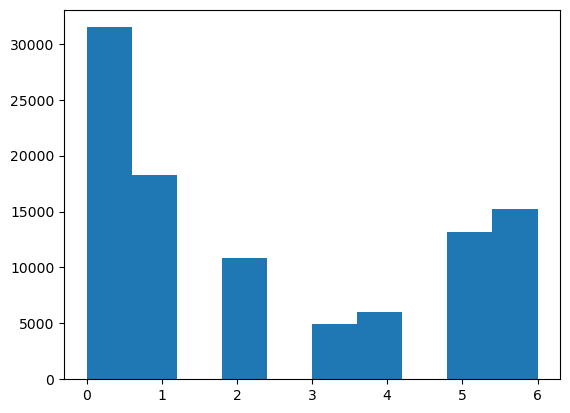

In [118]:
input = torch.tensor(dfx.values)
target = torch.tensor(dfy.values,dtype=torch.int8)
label = torch.argmax(target,dim=1)
pred = torch.argmax(input,dim=1)
weight = torch.tensor(dfw.values)
cm = torch.zeros(7,7)
for t, p, w in zip(label.view(-1), pred.view(-1), weight.view(-1)):
    cm[p,t] += w
cm =cm[1:, :]
O = cm.sum(dim=1)
def NLL(mu1,mu2,mu3,mu4,mu5,mu6):
    theta = torch.tensor([1.0,mu1,mu2,mu3,mu4,mu5,mu6],dtype=torch.float32)
    return -(O@(torch.log(cm.T@theta))-(cm.T@theta).sum())
m = Minuit(NLL, mu1=1, mu2=1, mu3=1, mu4=1, mu5=1, mu6=1)
m.limits = [(0.0, None)] * 6
m.strategy = 2
m.migrad()
print(cm)

In [60]:
torch.trace(torch.tensor(m.covariance))

tensor(13.7366, dtype=torch.float64)

In [70]:
torch.trace(torch.tensor(m.covariance,dtype=torch.float32))

tensor(581.0189)

In [101]:
cm = torch.zeros(6,7)
cm[3,:] = torch.ones(7)
O = torch.rand(6)
t = torch.tensor([1,0,0,0,0,0,0],dtype=torch.float32)

In [102]:
cm

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

In [103]:
torch.log(cm@t)

tensor([-inf, -inf, -inf, 0., -inf, -inf])